# Clustering using betweenness-based graph algorithms

In [6]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import warnings
%run data_cleaning.ipynb

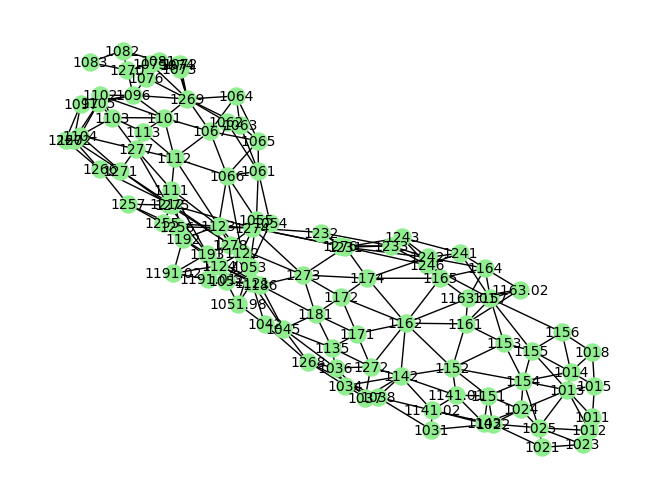

In [7]:
# import data
centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")
race_data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\weighted_dual_list",delimiter='%')
nx.draw(stl, with_labels=True, node_size=150, node_color='lightgreen', font_size=10)

In [8]:
by_tract = clean(census_data, race_data)
centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "LAT", "INTPTLON" : "LON"})
full_data = by_tract.merge(centroid_locations_small, on='location')
full_data.head()

,location,estimate,transit weight,income weight,race weight,LAT,LON
0,Census Tract 1011,1039,0.003275,0.009653,0.007499,38.554718,-90.273620
1,Census Tract 1012,1921,0.001162,0.009570,0.012480,38.561824,-90.274863
2,Census Tract 1013,2161,0.003697,0.009560,0.013909,38.566560,-90.264211
3,Census Tract 1014,1502,0.010036,0.009614,0.010099,38.562243,-90.253522
4,Census Tract 1015,1318,0.003381,0.009645,0.008554,38.548544,-90.264511


In [9]:
def mod_max(graph, k):
    tolerance = 1e-5
    orig = graph.copy()
    to_return = graph.copy()
    q = 0
    q_new = 0
    partition = [orig]
    new_partition = []

    while (len(partition) < k):
        for G in partition:
            # compute modularity matrix B
            G_nodes = list(G.nodes())
            s = np.zeros(len(G_nodes))
            A = nx.to_numpy_array(G)
            degs = list(dict(G.degree()).values())
            B = np.zeros(np.shape(A))
            n = len(G_nodes)
            m = len(G.edges())
            for i in range(n):
                for j in range(n):
                    B[i][j] = A[i][j] - degs[i]*degs[j]/(2*m)
            # find leading eigenvector u of B
            val, vec = np.linalg.eig(B)
            idx = np.argsort(val)[-1]
            largest_vec = vec[:,idx]
            
            # divide nodes into two groups by sign of leading eigenvector
            for i in range(len(largest_vec)):
                if largest_vec[i].real < 0:
                    s[i] = -1
                else:
                    s[i] = 1
            
            # create new subgraphs
            n1 = [G_nodes[i] for i in range(n) if s[i] == 1]
            n2 = [G_nodes[i] for i in range(n) if s[i] == -1]
            if len(n1) >= 1:
                new_partition.append(G.subgraph(n1))
            if len(n2) >= 1:
                new_partition.append(G.subgraph(n2))
            
            # update q_new
            q_new = q_new + B.sum()
        
        
        # either stop or re-partition graph
        q_new = q_new / (2*m)
        if abs(q_new - q) > tolerance and q_new < q:
            return partition
        
        else:
            q = q_new
            q_new = 0 
            partition = new_partition
            new_partition = []

    if len(partition) > k: # (this happens if k is odd)
        num_to_combine = len(partition) - k # we need to re-combine this many graphs to get back to k subgraphs
        pairs = [(partition[i], partition[i + 1]) for i in range(0, len(partition), 2)]
        to_test = list(itertools.combinations(pairs, num_to_combine))
        
        # test modularity of all possible combinations to make partition have length k
        best_modularity = 0
        test_idx = 0
        best_test_idx = 0
        for test in to_test:
            partition_copy = partition.copy()
            # remove the pair from the partition and add back in the original before it split into that pair
            for pair in test:
                partition_copy.remove(pair[0])
                partition_copy.remove(pair[1])
                nodes_to_find = list(set(pair[0].nodes()).union(pair[1].nodes()))
                back_together = orig.subgraph(nodes_to_find)
                partition_copy.append(back_together)
            # re-compute modularity and compare to best modularity
            communities = []
            for clust in partition_copy:
                nodes_in_clust = {n for n in clust.nodes()}
                communities.append(nodes_in_clust)
            modularity = nx.community.modularity(orig, communities)
            if modularity > best_modularity:
                best_modularity = modularity
                best_test_idx = test_idx     
            test_idx = test_idx + 1
        
        # choose the test with the best modularity and combine the pairs in that test for the final result
        final_partition = partition.copy()
        for pair in to_test[best_test_idx]:
            final_partition.remove(pair[0])
            final_partition.remove(pair[1])
            nodes_to_find = list(set(pair[0].nodes()).union(pair[1].nodes()))
            back_together = orig.subgraph(nodes_to_find)
            final_partition.append(back_together)
            
    else: # if k was even
        final_partition = partition

    value_dict = dict()
    idx = 0
    for sub in final_partition:
        for n in sub.nodes():
            value_dict[n] = idx
        idx = idx + 1
    nx.set_node_attributes(to_return, value_dict, 'cluster')
    return to_return

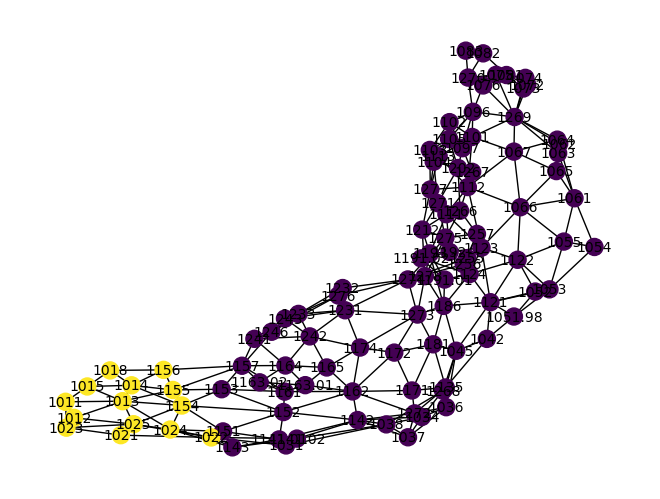

In [13]:
k = 2
test = mod_max(stl,k)
colors = [test.nodes[node]['cluster'] for node in test.nodes()]
nx.draw(test, with_labels=True, node_size=150, node_color=colors, font_size=10)
plt.show()